# Geospatial data analysis on the Planetary Computer

This deep dive covers various geospatial data analysis topics.

## Data Access

As covered in previous deep dives, the Planetary Computer uses STAC to catalog all the data available. We'll use STAC for data access throughout this deep dive.

In [ ]:
import pystac_client
import planetary_computer
import stackstac
import rasterio
import xrspatial.multispectral
import matplotlib.pyplot as plt
import numpy as np

## Coregistration

When you're working with data from multiple sources, you'll want to coregister, or align, your data. This ensures that a value at position `(x, y)` from one dataset represents the same area as the value at position `(x, y)` from some other dataset.

This example loads some data near Yazoo National Wildlife Refuge ([explorer](https://planetarycomputer.microsoft.com/explore?c=-90.9831%2C33.0868&z=12.20&d=sentinel-2-l2a&m=Most+recent+%28low+cloud%29&r=Natural+color)). We'll search for some STAC items over this area from Sentinel-2 Level 2-A.

In [ ]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-91.92, 33.43],
            [-90.74, 33.41],
            [-90.76, 32.42],
            [-91.93, 32.44],
            [-91.92, 33.43],
        ]
    ],
}
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)

sentinel_search = catalog.search(
    intersects=area_of_interest,
    datetime="2020-09-07/2020-09-08",
    collections=["sentinel-2-l2a"],
)

sentinel_item = next(sentinel_search.get_items())  # select the first item
sentinel_item = planetary_computer.sign(sentinel_item)

And from Landsat 8 Collection 2 Level 2.

In [ ]:
sentinel_item.geometry

In [ ]:
time_of_interest = "2020-09-01/2020-09-30"

search = catalog.search(
    collections=["landsat-8-c2-l2"],
    intersects=sentinel_item.geometry,
    datetime=time_of_interest,
    query={
        "eo:cloud_cover": {
            "lt": 10,
        }
    },
)

landsat_items = [planetary_computer.sign(item).to_dict() for item in search.get_items()]

Now we'll load these two datasets with xarray and stackstac.

In [ ]:
sentinel_data = (
    (
        stackstac.stack(
            sentinel_item,
            resolution=100,
            assets=["B02", "B03", "B04", "B08"],  # blue, green, red, nir
        )
        .where(lambda x: x > 0)  # sentinel-2 uses 0 as nodata
        .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
    )
    .isel(time=0)
    .persist()
)
sentinel_data

Now we'll load the Landsat data, but we'll make sure to coregister it with the Sentinel data. This will include

- resampling the Landsat item to match the resolution of the Sentinel data
- reprojecting the Landsat items to the CRS of the Sentinel data
- cropping the Landsat data to the bounds of the Sentinel data

In [ ]:
landsat_data = (
    (
        stackstac.stack(
            landsat_items,
            resolution=sentinel_data.resolution,  # resample to Sentinel data resolution
            epsg=sentinel_data.spec.epsg,  # reporoject to CRS of Sentinel data
            bounds=sentinel_data.spec.bounds,  # set bounds to match Sentinel data
            assets=["SR_B2", "SR_B3", "SR_B4", "SR_B5"],  # blue, green, red, nir
        )
        .where(lambda x: x > 0)  # landsat-8 uses 0 as nodata
        .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
    )
    .pipe(stackstac.mosaic)
    .persist()
)

landsat_data.spec, landsat_data.shape

In [ ]:
landsat_data

Now the data are coregistered. The coordinates match, so the values at each coordinate represent the same area on earth.

In [ ]:
(landsat_data.x.data == sentinel_data.x.data).all()

In [ ]:
(landsat_data.y.data == sentinel_data.y.data).all()

In [ ]:
import xarray as xr

data = xr.Dataset(
    data_vars=dict(
        sentinel=(["band", "y", "x"], sentinel_data.data),
        landsat=(["band", "y", "x"], landsat_data.data),
    ),
    coords=dict(
        x=sentinel_data.x.data,
        y=sentinel_data.y.data,
        band=sentinel_data.band.data,
    ),
    attrs=sentinel_data.attrs,  # both dataset have the same attributes
)

data

With this coregistered dataset, we can do operations using data from each source. For example, you could compute NDVI using a red band from Landsat 8 and a near-infrared band from Sentinel 2.

In [ ]:
nir = data.sentinel.sel(band="nir")
red = data.landsat.sel(band="red")

ndvi = (nir - red) / (nir + red)
fig, ax = plt.subplots(figsize=(16, 12))
ndvi.plot(ax=ax)
ax.set_axis_off()

## Surface tools

Surface tools help you visualize and analyze elevation data. In this example, we'll look at data around Grand Teton National Park using data from the NASADEM digital elevation model ([explorer](https://planetarycomputer.microsoft.com/explore?c=-109.8162%2C43.5419&z=7.43&d=nasadem&r=Elevation+%28terrain%29&m=Most+recent)).

In [13]:
import planetary_computer as pc
import pystac_client
import stackstac

from datashader import Canvas
from datashader.colors import Elevation
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from xrspatial.utils import height_implied_by_aspect_ratio

In [15]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)
point = {"type": "Point", "coordinates": [-110.6818, 43.7904]}

search = catalog.search(collections=["nasadem"], intersects=point, limit=1)
nasadem_item = next(search.get_items())

nasadem_item

<Item id=NASADEM_HGT_n43w111>

In [16]:
elevation_raster = stackstac.stack(
    [pc.sign(nasadem_item).to_dict()],
    epsg=6933,
    resampling=rasterio.enums.Resampling.bilinear,
    chunksize=2048,
).squeeze()

elevation_raster

<xarray.DataArray 'stackstac-2d92b8d54b9b81c16ae6e3dde4f6e2c1' (y: 3632, x: 3602)>
dask.array<getitem, shape=(3632, 3602), dtype=float64, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
    time            datetime64[ns] 2000-02-20
    id              <U19 'NASADEM_HGT_n43w111'
    band            <U9 'elevation'
  * x               (x) float64 -1.071e+07 -1.071e+07 ... -1.061e+07 -1.061e+07
  * y               (y) float64 5.089e+06 5.089e+06 ... 4.995e+06 4.995e+06
    proj:transform  object {0.0, 1.0, -0.0002777777777777778, 44.000138888888...
    proj:epsg       int64 4326
    proj:shape      object {3601}
    proj:bbox       object {-111.00013888888888, 42.999861111111116, -109.999...
    title           <U9 'Elevation'
    epsg            int64 6933
Attributes:
    spec:           RasterSpec(epsg=6933, bounds=(-10710003.909968996, 499534...
    crs:            epsg:6933
    transform:      | 26.80, 0.00,-10710003.91|\n| 0.00,-25.66, 5088530.14|\n...
    resolution_xy:  (26.80174451507628, 25.656756352633238)

In [17]:
# get full extent of raster
full_extent = (
    elevation_raster.coords["x"].min().item(),
    elevation_raster.coords["y"].min().item(),
    elevation_raster.coords["x"].max().item(),
    elevation_raster.coords["y"].max().item(),
)

# get ranges
x_range = (full_extent[0], full_extent[2])
y_range = (full_extent[1], full_extent[3])

# set width and height
W = 300
H = height_implied_by_aspect_ratio(W, x_range, y_range)

cvs = Canvas(plot_width=W, plot_height=H, x_range=x_range, y_range=y_range)

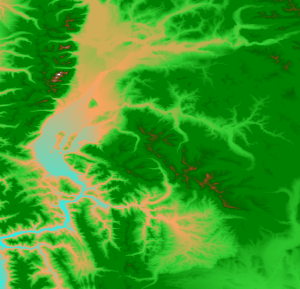

In [18]:
elevation_small = cvs.raster(
    elevation_raster,
)
elevation_img = shade(elevation_small, cmap=Elevation, how="linear")
elevation_img

In [19]:
from xrspatial import hillshade

hillshade_raster = hillshade(elevation_raster)
hillshade_raster

<xarray.DataArray 'hillshade' (y: 3632, x: 3602)>
dask.array<_trim, shape=(3632, 3602), dtype=float64, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
    time            datetime64[ns] 2000-02-20
    id              <U19 'NASADEM_HGT_n43w111'
    band            <U9 'elevation'
  * x               (x) float64 -1.071e+07 -1.071e+07 ... -1.061e+07 -1.061e+07
  * y               (y) float64 5.089e+06 5.089e+06 ... 4.995e+06 4.995e+06
    proj:transform  object {0.0, 1.0, -0.0002777777777777778, 44.000138888888...
    proj:epsg       int64 4326
    proj:shape      object {3601}
    proj:bbox       object {-111.00013888888888, 42.999861111111116, -109.999...
    title           <U9 'Elevation'
    epsg            int64 6933
Attributes:
    spec:           RasterSpec(epsg=6933, bounds=(-10710003.909968996, 499534...
    crs:            epsg:6933
    transform:      | 26.80, 0.00,-10710003.91|\n| 0.00,-25.66, 5088530.14|\n...
    resolution_xy:  (26.80174451507628, 25.656756352633238)

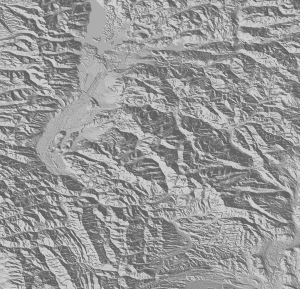

In [20]:
hillshade_img = shade(
    cvs.raster(hillshade_raster),
    cmap=["#333333", "#C7C7C7"],
    alpha=200,
)

hillshade_img

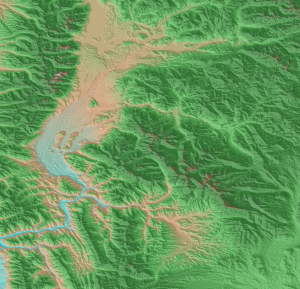

In [21]:
terrain_img = shade(elevation_small, cmap=Elevation, alpha=128, how="linear")
stack(hillshade_img, terrain_img)

In [23]:
from xrspatial import aspect
from datashader.colors import viridis

aspect_raster = aspect(elevation_raster)
aspect_raster

<xarray.DataArray 'aspect' (y: 3632, x: 3602)>
dask.array<_trim, shape=(3632, 3602), dtype=float64, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
    time            datetime64[ns] 2000-02-20
    id              <U19 'NASADEM_HGT_n43w111'
    band            <U9 'elevation'
  * x               (x) float64 -1.071e+07 -1.071e+07 ... -1.061e+07 -1.061e+07
  * y               (y) float64 5.089e+06 5.089e+06 ... 4.995e+06 4.995e+06
    proj:transform  object {0.0, 1.0, -0.0002777777777777778, 44.000138888888...
    proj:epsg       int64 4326
    proj:shape      object {3601}
    proj:bbox       object {-111.00013888888888, 42.999861111111116, -109.999...
    title           <U9 'Elevation'
    epsg            int64 6933
Attributes:
    spec:           RasterSpec(epsg=6933, bounds=(-10710003.909968996, 499534...
    crs:            epsg:6933
    transform:      | 26.80, 0.00,-10710003.91|\n| 0.00,-25.66, 5088530.14|\n...
    resolution_xy:  (26.80174451507628, 25.656756352633238)

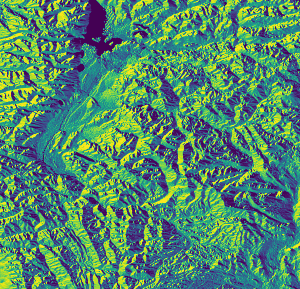

In [24]:
aspect_img = shade(cvs.raster(aspect_raster), cmap=viridis)
aspect_img

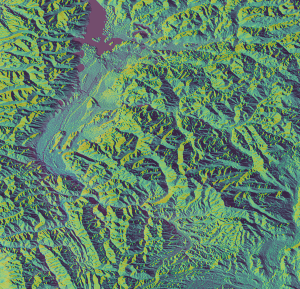

In [25]:
aspect_img = shade(cvs.raster(aspect_raster), cmap=viridis, alpha=128)
stack(elevation_img, hillshade_img, aspect_img)

xarray-spatial implements various other surface analysis tools like `curvature` and `slope`.

## Proximity

Proximity tools help you measure the distance between points. In this example, we'll use the JRC Global Surface Water dataset to measure the distance to the nearest water for a region of the Amazon rainforest.

[Explorer](https://planetarycomputer.microsoft.com/explore?c=-52.5652%2C-7.4759&z=4.00&d=jrc-gsw&m=Most+recent&r=Water+occurrence])

In [26]:
from xrspatial import proximity
from matplotlib.colors import Normalize, ListedColormap

bounds = [-57.151965, -2.530125, -55.710724, -1.179033]

jrc = catalog.search(collections=["jrc-gsw"], bbox=bounds)

items = list(jrc.get_items())
print(f"Returned {len(items)} Items")

Returned 1 Items


In [27]:
item = items[0]

assets_of_interest = ["extent", "seasonality", "transitions"]

data = (
    stackstac.stack(
        [pc.sign(item).to_dict()],
        assets=assets_of_interest,
        bounds=bounds,
        chunksize=3000,
    )
    .isel(time=0)
    .persist()
)

data

<xarray.DataArray 'stackstac-7d8a4e3a79547f8c50264548d89fdc62' (band: 3, y: 5405, x: 5766)>
dask.array<getitem, shape=(3, 5405, 5766), dtype=float64, chunksize=(1, 3000, 3000), chunktype=numpy.ndarray>
Coordinates: (12/16)
    time            datetime64[ns] 2020-07-01
    id              <U15 '60W_0Nv1_3_2020'
  * band            (band) <U11 'extent' 'seasonality' 'transitions'
  * x               (x) float64 -57.15 -57.15 -57.15 ... -55.71 -55.71 -55.71
  * y               (y) float64 -1.179 -1.179 -1.179 -1.18 ... -2.53 -2.53 -2.53
    start_datetime  (band) object None '2020-01-01T00:00:00Z' None
    ...              ...
    proj:shape      object {40000}
    sci:citation    <U169 'Jean-Francois Pekel, Andrew Cottam, Noel Gorelick,...
    proj:bbox       object {0.0, -60.0, -50.0, -10.0}
    description     (band) <U189 'Provides information on all the locations e...
    title           (band) <U20 'Maximum Water Extent' ... 'Water Transitions'
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-57.152, -2.53025, -55.7105, -...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-57.15|\n| 0.00,-0.00,-1.18|\n| 0.00, 0.00, 1.00|
    resolution:  0.00025

In [28]:
cmaps = {}

for asset_key in assets_of_interest:
    asset = item.assets[asset_key]
    with rasterio.open(pc.sign(item.assets[asset_key].href)) as src:
        colormap_def = src.colormap(1)  # get metadata colormap for band 1
        colormap = [
            np.array(colormap_def[i]) / 256 for i in range(256)
        ]  # transform to matplotlib color format
    cmaps[asset_key] = ListedColormap(colormap)

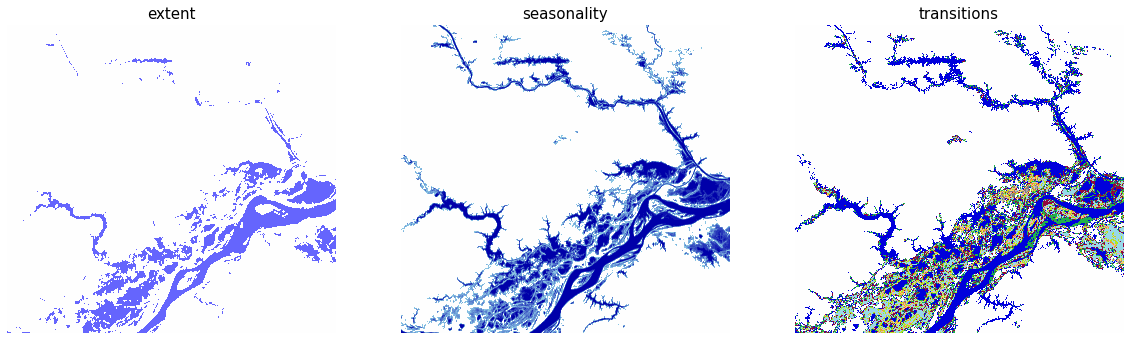

In [29]:
norm = Normalize(0, 255)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))

for i, asset_key in enumerate(assets_of_interest):
    ax[i].imshow(
        data.sel(band=asset_key),
        norm=norm,
        cmap=cmaps[asset_key],
    )
    ax[i].set_title(asset_key, fontdict={"fontsize": 15})
    ax[i].set_axis_off()

We'll use xarray-spatial's `proximity` function. By default, this computes the distance (euclidean by default) from each point in the dataset to the nearest *non-zero* point. That works well with the JRC dataset, which sets points that aren't covered by water to 0.

In [30]:
extent_data = data.sel(band="extent").compute()
extent_data

<xarray.DataArray 'stackstac-7d8a4e3a79547f8c50264548d89fdc62' (y: 5405, x: 5766)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])
Coordinates: (12/16)
    time            datetime64[ns] 2020-07-01
    id              <U15 '60W_0Nv1_3_2020'
    band            <U11 'extent'
  * x               (x) float64 -57.15 -57.15 -57.15 ... -55.71 -55.71 -55.71
  * y               (y) float64 -1.179 -1.179 -1.179 -1.18 ... -2.53 -2.53 -2.53
    start_datetime  object None
    ...              ...
    proj:shape      object {40000}
    sci:citation    <U169 'Jean-Francois Pekel, Andrew Cottam, Noel Gorelick,...
    proj:bbox       object {0.0, -60.0, -50.0, -10.0}
    description     <U189 'Provides information on all the locations ever det...
    title           <U20 'Maximum Water Extent'
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-57.152, -2.53025, -55.7105, -...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-57.15|\n| 0.00,-0.00,-1.18|\n| 0.00, 0.00, 1.00|
    resolution:  0.00025

In [31]:
extent_proximity_default = proximity(extent_data)
extent_proximity_default.name = """
    Water Extent proximity distance
    (Euclidean max_distance=infinity)
"""

In [33]:
extent_proximity_default

<xarray.DataArray '\n    Water Extent proximity distance\n    (Euclidean max_distance=infinity)\n' (y: 5405, x: 5766)>
array([[0.1372582 , 0.13700821, 0.13675823, ..., 0.01077033, 0.01086566,
        0.01096586],
       [0.13725569, 0.1370057 , 0.13675571, ..., 0.01053862, 0.01063602,
        0.01073837],
       [0.13725364, 0.13700365, 0.13675366, ..., 0.01030776, 0.01040733,
        0.0105119 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.15853864, 0.15876181,
        0.15898506],
       [0.        , 0.        , 0.        , ..., 0.15865154, 0.15887456,
        0.15909765],
       [0.        , 0.        , 0.        , ..., 0.15876476, 0.15898762,
        0.15921055]])
Coordinates: (12/16)
    time            datetime64[ns] 2020-07-01
    id              <U15 '60W_0Nv1_3_2020'
    band            <U11 'extent'
  * x               (x) float64 -57.15 -57.15 -57.15 ... -55.71 -55.71 -55.71
  * y               (y) float64 -1.179 -1.179 -1.179 -1.18 ... -2.53 -2.53 -2.53
    start_datetime  object None
    ...              ...
    proj:shape      object {40000}
    sci:citation    <U169 'Jean-Francois Pekel, Andrew Cottam, Noel Gorelick,...
    proj:bbox       object {0.0, -60.0, -50.0, -10.0}
    description     <U189 'Provides information on all the locations ever det...
    title           <U20 'Maximum Water Extent'
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-57.152, -2.53025, -55.7105, -...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-57.15|\n| 0.00,-0.00,-1.18|\n| 0.00, 0.00, 1.00|
    resolution:  0.00025

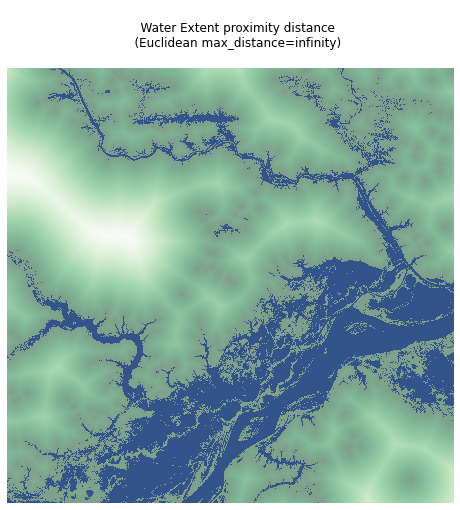

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))

extent_proximity_default.plot.imshow(cmap="Greens_r", add_colorbar=False, ax=ax)
extent_data.plot.imshow(
    norm=norm, cmap=cmaps["extent"], add_colorbar=False, alpha=0.5, ax=ax
)
ax.set_axis_off()
ax.set(title=extent_proximity_default.name);

There are various other ways to compute proximity, for example the direction to the nearest water.

## Zonal statistics

Zonal statistics help you better understand data from one source by analyzing it for different zones defined by another source.

* One dataset gives the *zones* (typically discrete integer codes)
* A second dataset gives the *values*, which are aggregated per zone

In [34]:
bounds = (-98.00080760573508, 32.99921674609716, -96.9991860639418, 34.000729644613706)

landcover_search = catalog.search(collections=["io-lulc"], bbox=bounds)
landcover_items = list(landcover_search.get_items())
signed_items = [pc.sign(item).to_dict() for item in landcover_items]

landcover_data = (
    stackstac.stack(
        signed_items,
        epsg=3857,
        bounds_latlon=bounds,
        dtype="int8",
        fill_value=0,
        chunksize=2048,
        resolution=100,
    )
    .pipe(stackstac.mosaic)
    .squeeze()
    .rename("Landcover")
    .persist()
)
landcover_data

<xarray.DataArray 'Landcover' (y: 1338, x: 1115)>
dask.array<getitem, shape=(1338, 1115), dtype=int8, chunksize=(1338, 1115), chunktype=numpy.ndarray>
Coordinates:
    band               <U4 'data'
  * x                  (x) float64 -1.091e+07 -1.091e+07 ... -1.08e+07 -1.08e+07
  * y                  (y) float64 4.029e+06 4.029e+06 ... 3.895e+06 3.895e+06
    start_datetime     <U20 '2020-01-01T00:00:00Z'
    end_datetime       <U20 '2021-01-01T00:00:00Z'
    label:type         <U6 'raster'
    label:description  <U4 'lulc'
    proj:shape         object {74688, 101302}
    label:properties   object None
    label:classes      object {'name': '', 'classes': ['nodata', 'water', 'tr...
    raster:bands       object {'nodata': 0, 'spatial_resolution': 10}
    epsg               int64 3857
Attributes:
    spec:        RasterSpec(epsg=3857, bounds=(-10909400, 3895100, -10797900,...
    crs:         epsg:3857
    transform:   | 100.00, 0.00,-10909400.00|\n| 0.00,-100.00, 4028900.00|\n|...
    resolution:  100

In [35]:
landcover_labels = dict(
    enumerate(landcover_data.coords["label:classes"].item()["classes"])
)
landcover_labels

{0: 'nodata',
 1: 'water',
 2: 'trees',
 3: 'grass',
 4: 'flooded veg',
 5: 'crops',
 6: 'scrub',
 7: 'built area',
 8: 'bare',
 9: 'snow/ice',
 10: 'clouds'}

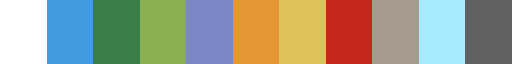

In [36]:
import numpy as np
from matplotlib.colors import ListedColormap

class_count = len(landcover_labels)

with rasterio.open(signed_items[0]["assets"]["data"]["href"]) as src:
    landcover_colormap_def = src.colormap(1)  # get metadata colormap for band 1
    landcover_colormap = [
        np.array(landcover_colormap_def[i]) / 255 for i in range(class_count)
    ]

landcover_cmap = ListedColormap(landcover_colormap)
landcover_cmap

In [37]:
sentinel_search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bounds,
    datetime="2020-07-01/2020-07-30",
    query={
        "eo:cloud_cover": {
            "lt": 10,
        }
    },
)

sentinel_items = [pc.sign(item).to_dict() for item in sentinel_search.get_items()]

sentinel_data = (
    (
        stackstac.stack(
            sentinel_items,
            resolution=landcover_data.resolution,
            epsg=landcover_data.spec.epsg,
            bounds=landcover_data.spec.bounds,
            assets=["B02", "B03", "B04", "B08"],  # blue, green, red, nir
            chunksize=2048,
        )
        .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
        .where(lambda x: x > 0, other=np.nan)  # Sentinels uses 0 as nodata
    )
    .median(dim="time", keep_attrs=True)
    .persist()
)
sentinel_data

<xarray.DataArray 'stackstac-903fe6b0a1936533b4903cb1c747defd' (band: 4, y: 1338, x: 1115)>
dask.array<nanmedian, shape=(4, 1338, 1115), dtype=float64, chunksize=(1, 669, 1115), chunktype=numpy.ndarray>
Coordinates: (12/19)
  * band                                     (band) <U5 'blue' 'green' ... 'nir'
  * x                                        (x) float64 -1.091e+07 ... -1.08...
  * y                                        (y) float64 4.029e+06 ... 3.895e+06
    s2:product_type                          <U7 'S2MSI2A'
    instruments                              <U3 'msi'
    constellation                            <U10 'Sentinel 2'
    ...                                       ...
    proj:shape                               object {10980}
    title                                    (band) <U20 'Band 2 - Blue - 10m...
    common_name                              (band) <U5 'blue' 'green' ... 'nir'
    center_wavelength                        (band) float64 0.49 0.56 ... 0.842
    full_width_half_max                      (band) float64 0.098 ... 0.145
    epsg                                     int64 3857
Attributes:
    spec:        RasterSpec(epsg=3857, bounds=(-10909400, 3895100, -10797900,...
    crs:         epsg:3857
    transform:   | 100.00, 0.00,-10909400.00|\n| 0.00,-100.00, 4028900.00|\n|...
    resolution:  100

In [38]:
sentinel_img = xrspatial.multispectral.true_color(
    sentinel_data.sel(band="red"),
    sentinel_data.sel(band="green"),
    sentinel_data.sel(band="blue"),
    c=30,
    th=0.075,
    name="True color (Sentinel)",
)

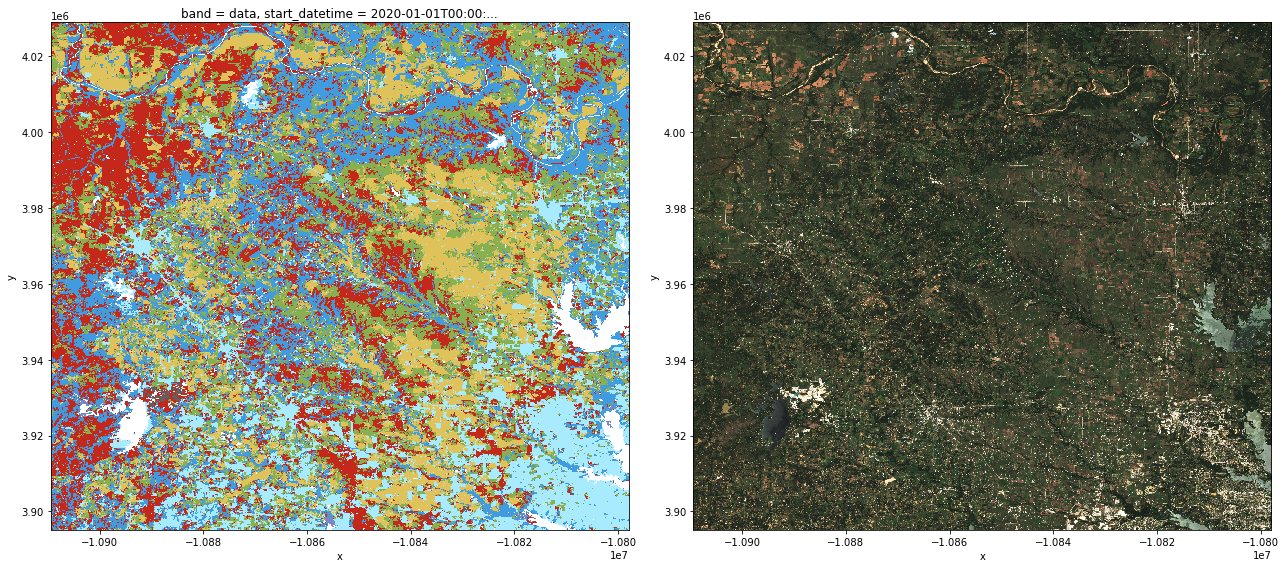

In [39]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 8))

landcover_data.plot.imshow(ax=ax1, cmap=landcover_cmap, add_colorbar=False)
sentinel_img.plot.imshow(ax=ax2)
plt.tight_layout()

In [40]:
red, nir = sentinel_data.sel(band=["red", "nir"])
ndvi = ((nir - red) / (nir + red)).persist()
ndvi

<xarray.DataArray 'stackstac-903fe6b0a1936533b4903cb1c747defd' (y: 1338, x: 1115)>
dask.array<truediv, shape=(1338, 1115), dtype=float64, chunksize=(669, 1115), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * x                                        (x) float64 -1.091e+07 ... -1.08...
  * y                                        (y) float64 4.029e+06 ... 3.895e+06
    s2:product_type                          <U7 'S2MSI2A'
    instruments                              <U3 'msi'
    constellation                            <U10 'Sentinel 2'
    s2:datatake_type                         <U8 'INS-NOBS'
    ...                                       ...
    sat:orbit_state                          <U10 'descending'
    s2:degraded_msi_data_percentage          float64 0.0
    s2:saturated_defective_pixel_percentage  float64 0.0
    gsd                                      int64 10
    proj:shape                               object {10980}
    epsg                                     int64 3857

So `landcover_data` is our *zones* raster, and `ndvi` is our `values` raster.

In [43]:
from xrspatial import zonal_stats

quantile_stats = zonal_stats(
    zones=landcover_data,
    values=ndvi,
    stats_funcs=["mean", "max", "min", "count"],
).compute()
quantile_stats

zone      mean       max       min   count
0     1  0.017884  0.846885 -0.443129   45139
1     2  0.743280  0.900511 -0.277344  339387
2     3  0.583749  0.877947 -0.140070  323999
3     4  0.547517  0.860692 -0.334288    1573
4     5  0.510050  0.882642 -0.252886  241772
5     6  0.577787  0.879797 -0.375246  336952
6     7  0.494027  0.878849 -0.388387  198272
7     8  0.087579  0.704829 -0.375067    4776

In [44]:
styler = (
    quantile_stats.set_index("zone")
    .rename(landcover_labels)
    .round(2)
    .style.format(precision=2)
    .background_gradient()
)
styler

In [45]:
elevation_raster

<xarray.DataArray 'stackstac-2d92b8d54b9b81c16ae6e3dde4f6e2c1' (y: 3632, x: 3602)>
dask.array<getitem, shape=(3632, 3602), dtype=float64, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
    time            datetime64[ns] 2000-02-20
    id              <U19 'NASADEM_HGT_n43w111'
    band            <U9 'elevation'
  * x               (x) float64 -1.071e+07 -1.071e+07 ... -1.061e+07 -1.061e+07
  * y               (y) float64 5.089e+06 5.089e+06 ... 4.995e+06 4.995e+06
    proj:transform  object {0.0, 1.0, -0.0002777777777777778, 44.000138888888...
    proj:epsg       int64 4326
    proj:shape      object {3601}
    proj:bbox       object {-111.00013888888888, 42.999861111111116, -109.999...
    title           <U9 'Elevation'
    epsg            int64 6933
Attributes:
    spec:           RasterSpec(epsg=6933, bounds=(-10710003.909968996, 499534...
    crs:            epsg:6933
    transform:      | 26.80, 0.00,-10710003.91|\n| 0.00,-25.66, 5088530.14|\n...
    resolution_xy:  (26.80174451507628, 25.656756352633238)